# Importing and cleaning the dataset

### Importing libraries and the dataset to be cleaned

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
import hdbscan

from scipy.cluster import hierarchy

from fancyimpute import KNN
from fancyimpute import MICE
from fancyimpute.bayesian_ridge_regression import BayesianRidgeRegression

from collections import defaultdict

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex, colorConverter
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-white')

Using TensorFlow backend.
/usr/lib/python3/dist-packages/matplotlib/__init__.py:874: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# import the csv dataset as a pandas DataFrame
df = pd.read_csv('data/full_data.csv')
# change index (row labels)
df = df.set_index('Country Code', verify_integrity=True)
# display df with all its columns
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
df.head()

,Country Name,Population_2014,Population_2015,Population_2016,Expense_%GDP_2014,Expense_%GDP_2015,Expense_%GDP_2016,ForeignDirectInvestment_NetInflows_BoP_currentUS$_2014,ForeignDirectInvestment_NetInflows_BoP_currentUS$_2015,ForeignDirectInvestment_NetInflows_BoP_currentUS$_2016,GDPgrowth_annual%_2014,GDPgrowth_annual%_2015,GDPgrowth_annual%_2016,Inflation_ConsumerPrices_annual%_2014,Inflation_ConsumerPrices_annual%_2015,Inflation_ConsumerPrices_annual%_2016,ExportsGoodsServices_%GDP_2014,ExportsGoodsServices_%GDP_2015,ExportsGoodsServices_%GDP_2016,GDP_currentUS$_2014,GDP_currentUS$_2015,GDP_currentUS$_2016,GDP_constantUS$_2014,GDP_constantUS$_2015,GDP_constantUS$_2016,ImportsGoodsServices_%GDP_2014,ImportsGoodsServices_%GDP_2015,ImportsGoodsServices_%GDP_2016,AccessElectricity_%population_2014,AccessElectricity_%population_2015,AccessElectricity_%population_2016,FossilFuelEnergyConsumption_%total_2014,FossilFuelEnergyConsumption_%total_2015,FossilFuelEnergyConsumption_%total_2016,EnergyUse_KgEquivalentPerCapita_2014,EnergyUse_KgEquivalentPerCapita_2015,EnergyUse_KgEquivalentPerCapita_2016,CO2Emissions_kt_2014,CO2Emissions_kt_2015,CO2Emissions_kt_2016,PovertyHeadcountRatio$1.90aday_2011PPP_%population_2014,PovertyHeadcountRatio$1.90aday_2011PPP_%population_2015,PovertyHeadcountRatio$1.90aday_2011PPP_%population_2016,Export_Petroleum_US $_2014,Export_Petroleum_US $_2015,Export_Petroleum_US $_2016,Export_Tot_US $_2014,Export_Tot_US $_2015,Export_Tot_US $_2016,Import_Petroleum_US $_2014,Import_Petroleum_US $_2015,Import_Petroleum_US $_2016,Import_Tot_US $_2014,Import_Tot_US $_2015,Import_Tot_US $_2016,AnnualHouseholdExpenditure_Gas_2010,AnnualHouseholdExpenditure_Electricity_2010,AnnualHouseholdExpenditure_Other fuels_2010,FinalConsumptionExpenditure_currentUS$_2014,FinalConsumptionExpenditure_currentUS$_2015,FinalConsumptionExpenditure_currentUS$_2016,FinalConsumptionExpenditure_constantUS$_2014,FinalConsumptionExpenditure_constantUS$_2015,FinalConsumptionExpenditure_constantUS$_2016,GNI_currentUS$_2014,GNI_currentUS$_2015,GNI_currentUS$_2016,GNI_constantUS$_2014,GNI_constantUS$_2015,GNI_constantUS$_2016,ImportsOfGoodsAndServices_currentUS$_2014,ImportsOfGoodsAndServices_currentUS$_2015,ImportsOfGoodsAndServices_currentUS$_2016,ImportsOfGoodsAndServices_constantUS$_2014,ImportsOfGoodsAndServices_constantUS$_2015,ImportsOfGoodsAndServices_constantUS$_2016,HouseholdsFinalConsumptionExpenditure_currentUS$_2014,HouseholdsFinalConsumptionExpenditure_currentUS$_2015,HouseholdsFinalConsumptionExpenditure_currentUS$_2016,HouseholdsFinalConsumptionExpenditure_constantUS$_2014,HouseholdsFinalConsumptionExpenditure_constantUS$_2015,HouseholdsFinalConsumptionExpenditure_constantUS$_2016,Production_Oil_bpd_2014,Production_Oil_bpd_2015,Production_Oil_bpd_2016,Import_Oil_bpd_2014,Import_Oil_bpd_2015,Import_Oil_bpd_2016,Export_Oil_bdp_2014,Export_Oil_bdp_2015,Export_Oil_bdp_2016,Reserves_Oil_2014,Reserves_Oil_2015,Reserves_Oil_2016
Country Code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
DZA,Algeria,3.911000e+07,3.987000e+07,4.061000e+07,NaN,NaN,NaN,1.503000e+09,-4.034000e+08,1.637000e+09,3.789121,3.763467,3.300000,2.916406,4.784977,6.397714,30.219117,23.186439,21.001758,2.138100e+11,1.658743e+11,1.590491e+11,1.828894e+11,1.897723e+11,1.960348e+11,31.926659,36.546459,35.270284,99.234344,99.336708,99.439568,99.977917,NaN,NaN,1321.099494,NaN,NaN,145400.0,NaN,NaN,NaN,NaN,NaN,3.490938e+10,1.860843e+10,1.678932e+10,6.038769e+10,3.479595e+10,2.999210e+10,2.638149e+09,2.263953e+09,1.532413e+09,5.861808e+10,5.180307e+10,4.709068e+10,NaN,NaN,NaN,1.200610e+11,1.039546e+11,1.010908e+11,9.998792e+10,1.027505e+11,1.056942e+11,2.091643e+11,1.614213e+11,1.574791e+11,1.778686e+11,1.839052e+11,1.939134e+11,6.826240e+10,6.062119e+10,56097067791.3911,6.548231e+10,6.968983e+10,6.759913e+10,7.774637e+10,6.806889e+10,68035412922.3313,6.748725e+10,70119251674.941,72433186980.4105,1420.000000,1429.000000,1348.360656,

### Dropping bad columns and rows

In [3]:
# dropping columns with too many missing values
def drop_poor_columns(dframe, p):
    ''' Drop the columns of dframe with more than p (%) missing values'''

    # create df with a the count of missing values for each column
    missing_df = pd.DataFrame(dframe.isnull().sum())
    # extract the names of columns with more than p (%) missing values
    poor_columns = missing_df.loc[missing_df[0] > p*len(dframe)].index
    # drop sparse columns
    dframe.drop(poor_columns, axis=1, inplace=True)
    return dframe, poor_columns

print('df.shape before', df.shape)
df, dropped = drop_poor_columns(df, 0.5)
print(dropped)

df.shape before (37, 94)
Index(['FossilFuelEnergyConsumption_%total_2015',
       'FossilFuelEnergyConsumption_%total_2016',
       'EnergyUse_KgEquivalentPerCapita_2015',
       'EnergyUse_KgEquivalentPerCapita_2016', 'CO2Emissions_kt_2015',
       'CO2Emissions_kt_2016',
       'PovertyHeadcountRatio$1.90aday_2011PPP_%population_2014',
       'PovertyHeadcountRatio$1.90aday_2011PPP_%population_2015',
       'PovertyHeadcountRatio$1.90aday_2011PPP_%population_2016',
       'AnnualHouseholdExpenditure_Gas_2010',
       'AnnualHouseholdExpenditure_Electricity_2010'],
      dtype='object')


In [4]:
# convert all columns but Country Names to numeric type
df.iloc[:,1:] = df.iloc[:,1:].apply(pd.to_numeric, errors='coerce')

### Dropping bad rows 

In [5]:
# dropping columns with too many missing values
def drop_poor_rows(dframe, p):
    ''' Drop the columns of dframe with more than p (%) missing values'''

    # create df with a the count of missing values for each column
    missing_df = pd.DataFrame(dframe.isnull().sum(axis=1))
    # extract the names of columns with more than p (%) missing values
    poor_rows = missing_df.loc[missing_df[0] > p*len(dframe.columns)].index
    # drop sparse columns
    dframe.drop(poor_rows, axis=0, inplace=True)
    return dframe, poor_rows

print('df.shape before', df.shape)
df, dropped = drop_poor_rows(df, 0.5)
print(dropped)

df.shape before (37, 83)
Index(['TKM', 'VEN'], dtype='object', name='Country Code')


In [6]:
# drop country name column
country_names = df['Country Name'].as_matrix()
df.drop('Country Name', axis=1, inplace=True)

/home/lupol/tensorflow/local/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [7]:
# list of remaining countries by biggest number of missing data
df.isnull().sum(axis=1).sort_values(ascending=False)

Country Code
LBY    38
IRQ    25
TUN    16
GAB    15
TLS    14
COG    13
KEN    12
GHA    11
OMN    11
MAR     7
NGA     7
VNM     5
AGO     5
LBN     5
DZA     4
CHN     4
CIV     4
ECU     4
PAK     3
MNE     3
MOZ     3
IRL     2
ITA     1
EGY     1
NOR     1
CYP     1
USA     1
ARE     1
AUS     1
GBR     1
PRT     1
KAZ     0
IDN     0
MEX     0
ZAF     0
dtype: int64

### Imputing missing values

In [8]:
# df is my data frame with the missings. I keep only floats
df_numeric = df.select_dtypes(include=[np.float64]).as_matrix()

# initialize MICE imputer
mice = MICE(visit_sequence='monotone', n_imputations=100, n_burn_in=10,
            n_pmm_neighbors=5, impute_type='col',
            model=BayesianRidgeRegression(lambda_reg=0.001),
            init_fill_method='mean', min_value=None, max_value=None, verbose=False)
# impute missing values
df_filled_MICE = pd.DataFrame(mice.complete(df_numeric))
df_filled_KNN = pd.DataFrame(KNN(3).complete(df_numeric))

df_filled_MICE.columns = df.columns
df_filled_MICE.index = df.index
df_filled_KNN.columns = df.columns
df_filled_KNN.index = df.index

/home/lupol/tensorflow/local/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Imputing row 1/35 with 4 missing, elapsed time: 0.002


### Exporting cleaned dataset

In [9]:
# export the cleaned dataframe to a csv file
df.to_csv('data/selected_countries_cleaned.csv')
df_filled_MICE.to_csv('data/selected_countries_cleaned_MICE.csv')
df_filled_KNN.to_csv('data/selected_countries_cleaned_KNN.csv')
# KNN gives much better results

## Principal Components Analysis

In [10]:
df = pd.read_csv('data/selected_countries_cleaned_KNN.csv')
# change index (row labels)
df = df.set_index('Country Code', verify_integrity=True)
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 35 entries, DZA to VNM
Columns: 82 entries, Population_2014 to Reserves_Oil_2016
dtypes: float64(82)
memory usage: 22.7+ KB


In [11]:
scale(df)

/home/lupol/tensorflow/local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


array([[-0.22313337, -0.22298877, -0.22284152, ..., -0.0596305 ,
        -0.0655537 , -0.05920087],
       [-0.27602166, -0.27481001, -0.27344465, ..., -0.16771041,
        -0.17321382, -0.18772976],
       [-0.29085988, -0.29211252, -0.2931713 , ..., -0.43022587,
        -0.43714823, -0.43376204],
       ...,
       [-0.1124975 , -0.1139959 , -0.11567438, ..., -0.37701781,
        -0.37674709, -0.3806189 ],
       [ 0.98947914,  0.99004238,  0.98987538, ...,  0.77747257,
         0.87070787,  0.7244953 ],
       [ 0.00868131,  0.00871817,  0.00856059, ..., -0.32810927,
        -0.32888043, -0.32462988]])

In [12]:
cols = df.columns
ind = df.index
df = pd.DataFrame(scale(df))
df.columns = cols
df.index = ind

/home/lupol/tensorflow/local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [13]:
# Fit the PCA model and transform df to get the principal components
pca = PCA()
df_pc = pd.DataFrame(pca.fit_transform(df), index=df.index)
df_pc.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 35 entries, DZA to VNM
Columns: 35 entries, 0 to 34
dtypes: float64(35)
memory usage: 9.8+ KB


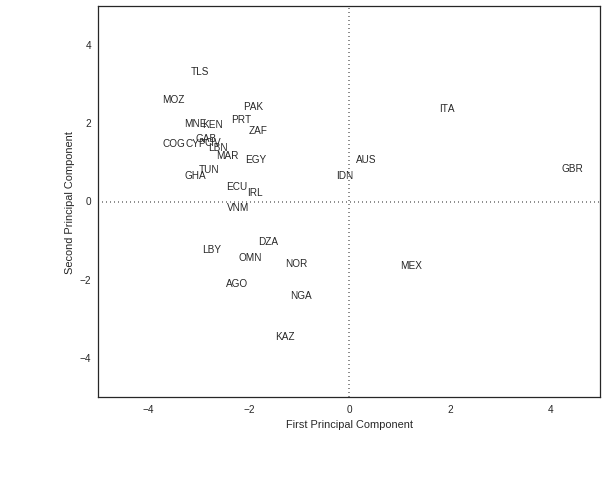

In [14]:
# plot countries along the first and second PCs
fig , ax1 = plt.subplots(figsize=(9,7))

ax1.set_xlim(-5,5)
ax1.set_ylim(-5,5)

# Plot Principal Components 1 and 2
for i in df_pc.index:
    ax1.annotate(i, (df_pc[0].loc[i], -df_pc[1].loc[i]), ha='center')

# Plot reference lines
ax1.hlines(0,-5,5, linestyles='dotted', colors='grey')
ax1.vlines(0,-5,5, linestyles='dotted', colors='grey')

ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
# possible to add loading vectors of features to understand what these PCs represent

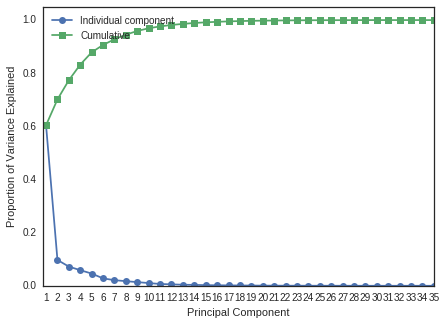

In [15]:
plt.figure(figsize=(7,5))

plt.plot(range(1, len(pca.components_)+1), pca.explained_variance_ratio_, '-o', label='Individual component')
plt.plot(range(1, len(pca.components_)+1), np.cumsum(pca.explained_variance_ratio_), '-s', label='Cumulative')

plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,4.25)
plt.ylim(0,1.05)
plt.xticks(range(1, len(pca.components_)+1))
plt.legend(loc=2);

## Hierarchical Clustering

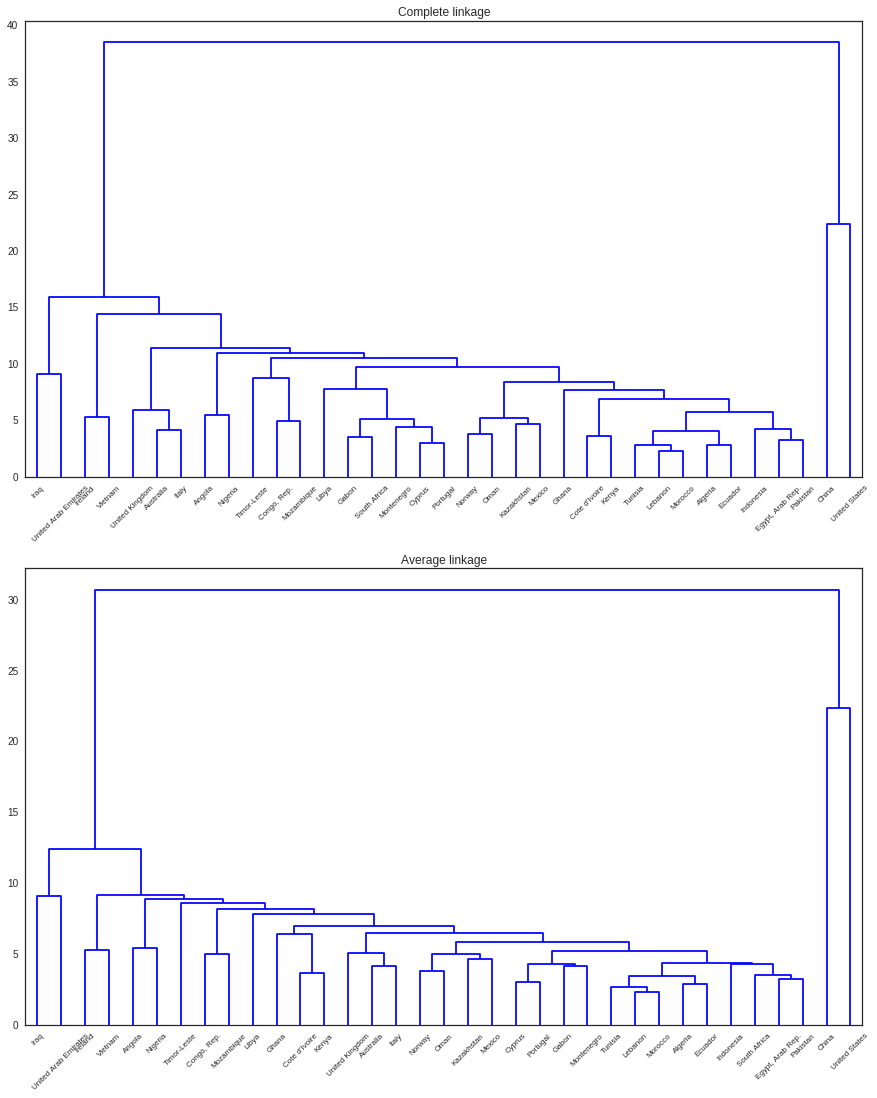

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,18))

for linkage, cluster, ax in zip([hierarchy.complete(df), hierarchy.average(df)],
                               ['c1','c2'], [ax1, ax2]):
    cluster = hierarchy.dendrogram(linkage, ax=ax, color_threshold=0, labels=country_names)
    
ax1.set_title('Complete linkage');
ax2.set_title('Average linkage');

In [17]:
# sns.set_palette('Set1', 10, 0.65)
# palette = sns.color_palette()
# hierarchy.set_link_color_palette(list(map(rgb2hex, palette)))
# sns.set_style('white')

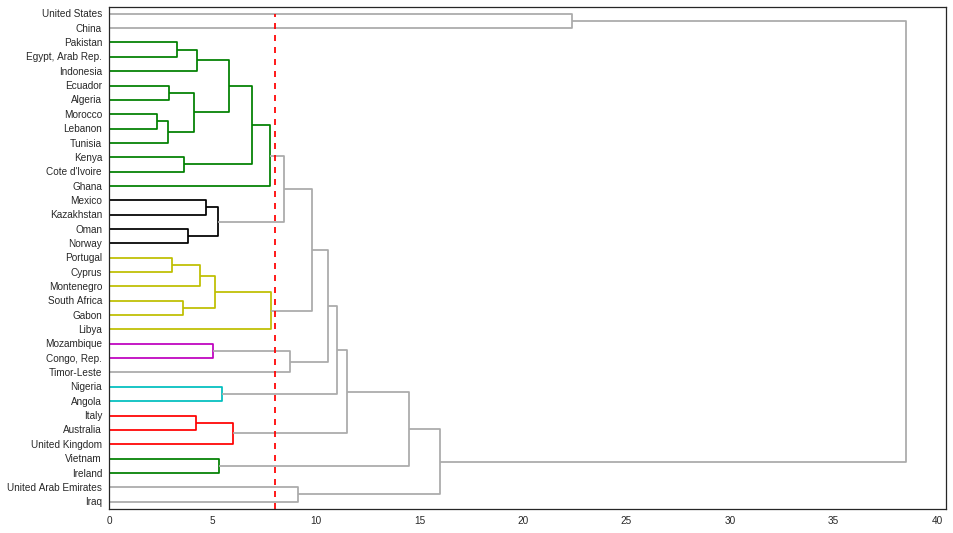

In [18]:
threshold = 8
plt.figure(figsize=(15, 9))
den = hierarchy.dendrogram(hierarchy.complete(df), orientation='right',
                     labels=country_names, color_threshold=threshold,
                     above_threshold_color='#AAAAAA', leaf_font_size=10)
plt.vlines(threshold,0,plt.gca().yaxis.get_data_interval()[1], colors='r', linestyles='dashed');

In [19]:
Z = hierarchy.complete(df)
fcl = hierarchy.fcluster(Z, 8, criterion='distance')
sorted(list(zip(country_names, fcl)), key=lambda x: x[1])

[('Iraq', 1),
 ('United Arab Emirates', 2),
 ('Ireland', 3),
 ('Vietnam', 3),
 ('Australia', 4),
 ('Italy', 4),
 ('United Kingdom', 4),
 ('Angola', 5),
 ('Nigeria', 5),
 ('Congo, Rep.', 6),
 ('Mozambique', 6),
 ('Timor-Leste', 7),
 ('Cyprus', 8),
 ('Gabon', 8),
 ('Libya', 8),
 ('Montenegro', 8),
 ('Portugal', 8),
 ('South Africa', 8),
 ('Kazakhstan', 9),
 ('Mexico', 9),
 ('Norway', 9),
 ('Oman', 9),
 ('Algeria', 10),
 ("Cote d'Ivoire", 10),
 ('Ecuador', 10),
 ('Egypt, Arab Rep.', 10),
 ('Ghana', 10),
 ('Indonesia', 10),
 ('Kenya', 10),
 ('Lebanon', 10),
 ('Morocco', 10),
 ('Pakistan', 10),
 ('Tunisia', 10),
 ('China', 11),
 ('United States', 12)]

In [20]:
class Clusters(dict):
    def _repr_html_(self):
        html = '<table style="border: 0;">'
        for c in self:
            hx = rgb2hex(colorConverter.to_rgb(c))
            html += '<tr style="border: 0;">' \
            '<td style="background-color: {0}; ' \
                       'border: 0;">' \
            '<code style="background-color: {0};">'.format(hx)
            html += c + '</code></td>'
            html += '<td style="border: 0"><code>' 
            html += repr(self[c]) + '</code>'
            html += '</td></tr>'
        
        html += '</table>'
        
        return html

In [21]:
def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))
    
    cluster_classes = Clusters()
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l
    
    return cluster_classes



In [22]:
clus = get_cluster_classes(den)

In [23]:
clus


#AAAAAA,"['Iraq', 'United Arab Emirates', 'Timor-Leste', 'China', 'United States']"
r,"['Australia', 'Italy', 'United Kingdom']"
y,"['Gabon', 'South Africa', 'Cyprus', 'Portugal', 'Montenegro', 'Libya']"
g,"['Ireland', 'Vietnam', ""Cote d'Ivoire"", 'Kenya', 'Lebanon', 'Morocco', 'Tunisia', 'Algeria', 'Ecuador', 'Egypt, Arab Rep.', 'Pakistan', 'Indonesia', 'Ghana']"
c,"['Angola', 'Nigeria']"
m,"['Congo, Rep.', 'Mozambique']"
k,"['Norway', 'Oman', 'Kazakhstan', 'Mexico']"


### Based on principal components

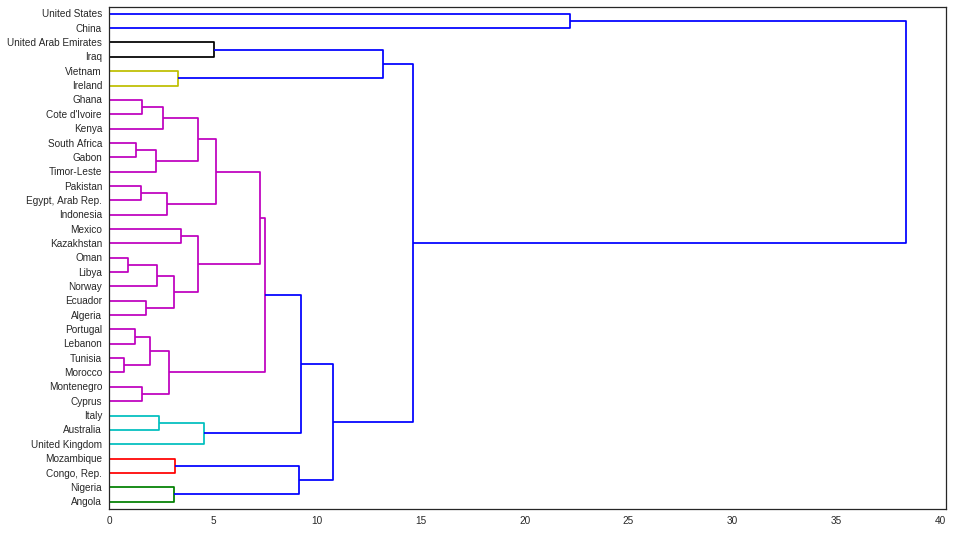

In [24]:
# Hierarchy based on Principal Components 1 to 5
plt.figure(figsize=(15, 9))
pca_cluster = hierarchy.dendrogram(hierarchy.complete(df_pc.iloc[:,:5]), labels=country_names, orientation='right', color_threshold=8, leaf_font_size=10)

## KMeans

In [25]:
np.random.seed(2)
km4 = KMeans(n_clusters=4, n_init=50)
km4.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=50, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [26]:
# Observations per KMeans cluster
cluster_map = pd.DataFrame(columns=['cluster'], index=country_names)
cluster_map['cluster'] = km4.labels_
cluster_map.sort_values('cluster').T

,Algeria,United Kingdom,Tunisia,Timor-Leste,South Africa,Portugal,Pakistan,Oman,Norway,Nigeria,Mozambique,Morocco,Montenegro,Mexico,Libya,Kenya,Lebanon,Ecuador,Angola,Australia,"Congo, Rep.",Cote d'Ivoire,Cyprus,Kazakhstan,Vietnam,Gabon,Ghana,Indonesia,Ireland,Italy,"Egypt, Arab Rep.",United States,China,Iraq,United Arab Emirates
cluster,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,3,3


### Based on principal components

In [27]:
clusterer = DBSCAN()
clusterer.fit_predict(df)
# Observations per KMeans cluster
cluster_map = pd.DataFrame(columns=['cluster'], index=country_names)
cluster_map['cluster'] = clusterer.labels_
cluster_map.sort_values('cluster').T

,Algeria,Mexico,Montenegro,Morocco,Mozambique,Nigeria,Norway,Libya,Oman,Portugal,South Africa,Timor-Leste,Tunisia,United Arab Emirates,United Kingdom,Pakistan,United States,Lebanon,Kazakhstan,Angola,Australia,China,"Congo, Rep.",Cote d'Ivoire,Cyprus,Kenya,Ecuador,Gabon,Ghana,Indonesia,Iraq,Ireland,Italy,"Egypt, Arab Rep.",Vietnam
cluster,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [28]:
clusterer

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=1, p=None)

## HDBSCAN

In [29]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=2)
clusterer.fit_predict(df)
# Observations per KMeans cluster
cluster_map = pd.DataFrame(columns=['cluster'], index=country_names)
cluster_map['cluster'] = clusterer.labels_
cluster_map.sort_values('cluster').T

,United States,United Arab Emirates,China,Timor-Leste,Iraq,Mexico,Montenegro,Morocco,Mozambique,Norway,Algeria,Libya,Portugal,South Africa,Tunisia,United Kingdom,Oman,Pakistan,Lebanon,Kazakhstan,Italy,Ireland,Indonesia,Ghana,Gabon,"Egypt, Arab Rep.",Ecuador,Cyprus,Cote d'Ivoire,"Congo, Rep.",Australia,Kenya,Vietnam,Nigeria,Angola
cluster,-1,-1,-1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


In [36]:
a = defaultdict(array)

NameError: name 'array' is not defined

In [34]:
a['bla'] = 1

In [35]:
a

defaultdict(str, {'bla': 1})